# Model Deployment 

## 1. TRAINING A MODEL

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from my_rnns import word_level_process_data,data_set_word_level
import requests
import json

In [ ]:
def get_txt_file(name,url):
        path_to_file = tf.keras.utils.get_file(name , url)
        text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
        print(f'Length of text: {len(text)} characters')
        return text

text = get_txt_file('shakespeare.txt','https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt')

Length of text: 4573338 characters


In [ ]:
word_level_text = text[:50000]
word_level_text = word_level_text.lower().split("\n")

In [ ]:
word_lvl_obj = word_level_process_data(word_level_text)
tokenizer = word_lvl_obj.word_level_process()


 The total words are :2081 


Do u want to print the word dictionary? (y/n)

y


The word index dictionary is :

 {'the': 1, 'and': 2, 'to': 3, 'you': 4, 'i': 5, 'of': 6, 'a': 7, 'in': 8, 'that': 9, 'he': 10, 'marcius': 11, 'not': 12, 'for': 13, 'your': 14, 'him': 15, 'it': 16, 'with': 17, 'my': 18, 'is': 19, 'have': 20, 'as': 21, 'be': 22, 'they': 23, 'we': 24, 'his': 25, 'are': 26, 'their': 27, 'first': 28, 'our': 29, 'but': 30, 'menenius': 31, 'me': 32, 'all': 33, 'what': 34, 'good': 35, 'shall': 36, 'this': 37, 'will': 38, 'than': 39, 'if': 40, 'no': 41, 'at': 42, 'us': 43, 'cominius': 44, 'them': 45, 'well': 46, 'so': 47, 'do': 48, 'citizen': 49, 'more': 50, 'would': 51, 'which': 52, 'make': 53, 'aufidius': 54, 'on': 55, 'or': 56, 'brutus': 57, 'volumnia': 58, 'were': 59, 'come': 60, 'by': 61, 'know': 62, 'where': 63, 'upon': 64, 'lartius': 65, 'one': 66, 'like': 67, 'from': 68, 'then': 69, 'rome': 70, "'tis": 71, 'was': 72, 'when': 73, 'how': 74, 'o': 75, 'must': 76, 'sicinius':

In [ ]:
data_word_level_obj = data_set_word_level(word_level_text,tokenizer)
X , Y , max_seq_length = data_word_level_obj.gen_data()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 256)           532736    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              488400    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2081)              626381    
                                                                 
Total params: 1,647,517
Trainable params: 1,647,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
235/235 [==============================] - 33s 103ms/step - loss: 6.6847 - accuracy: 0.0417 - lr: 0.0100
Epoch 2/50
235/235 [==============================] - 25s 107ms/step - loss: 5.9152 - accuracy: 0.0666 - lr: 0.0100
Epoch 3/50
2

Text(0, 0.5, 'loss')

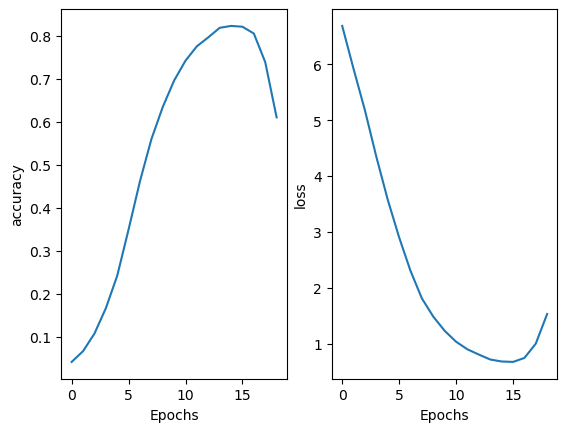

In [ ]:
callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='loss',
                                             mode='auto',
                                             verbose=1,
                                             patience=3),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                patience=3,
                                                verbose=1,
                                                factor=.5, 
                                                min_lr=0.0000001)
        ]

embedding_dim = 256
lstm_units = 150
learning_rate = 0.01
epochs = 50


model = tf.keras.models.Sequential([
          tf.keras.layers.Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_seq_length-1),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
          tf.keras.layers.Dense(len(tokenizer.word_index)+1, activation='softmax')
])


model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )


model.summary()


history = model.fit(X, Y, epochs=epochs , callbacks=callbacks)

plt.figure()
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')

## 2 . SAVING IN A FORMAT CONSUMABLE BY TF SERVING

In [ ]:
# Save the model in the SavedModel format
model_version = "1"
export_path = f"./saved_models/{model_version}"
tf.saved_model.save(model, export_path)

## 3. STARTING THE TF SERVING

 pip install tensorflow-serving-api

install docker for desktop from website

In command prompt
     
   docker pull tensorflow/serving 
   
   docker run -p 8501:8501 --name=tensorflow_serving_container --mount type=bind,source={PATH TO MODEL DIRECTORY},target=/models/{MODEL_NAME} -e MODEL_NAME={MODEL_NAME}  -t tensorflow/serving


Make requests using Python requests library 

   url = "http://localhost:8501/v1/models/{MODEL_NAME}:predict"

## 4. CHECKING THE MODEL DEPLOYED

In [ ]:
seed_text = 'thou heart stinks thee'

# Convert the seed text to a token sequence
token_list = tokenizer.texts_to_sequences([seed_text])[0]

# Pad the sequence
token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_seq_length-1, padding='pre')

token_list

array([[  0,   0,   0,   0,   0,   0,   0,   0,  80, 172, 128]])

In [ ]:
# Define the data to be sent in the request
data = {"instances": [[0,0,0,0,0,0,47,79,578,4,596]]}  # We need to input a list whereas the tokenizer outputs an array

# Convert the data to JSON
json_data = json.dumps(data)

# Set the URL for the request
url = "http://localhost:8501/v1/models/saved_model:predict"

# Send the request
response = requests.post(url, data=json_data)

# Print the response
print(response.json())  #the request returns probs , select highest prob and pick the word

{'predictions': [[6.05226802e-08, 6.99847733e-05, 0.0893771201, 0.00114834798, 0.000174000059, 0.000614746648, 2.84069472e-07, 0.000805966964, 0.0024139185, 0.000984489452, 2.34136405e-06, 2.45089523e-05, 5.22689625e-05, 0.00366477738, 0.000205276316, 0.000294753117, 6.90162924e-05, 0.126559317, 0.0462794267, 0.00126538449, 1.51666945e-05, 0.000167785489, 2.13302405e-06, 0.00422024773, 0.000263447582, 0.0677474588, 0.000774858461, 0.000355153461, 5.43734641e-05, 0.000252937782, 3.42086751e-05, 7.53491395e-06, 0.000347090448, 0.00182578457, 5.085461e-06, 0.000194200067, 3.42636866e-07, 0.00154820119, 0.00263437023, 4.28436238e-07, 0.000300609739, 0.0053415997, 4.68974031e-05, 2.30892027e-07, 6.20432911e-05, 5.80101732e-05, 3.31737683e-05, 2.8810436e-07, 0.000256271858, 3.98132488e-06, 7.53814529e-05, 4.3660757e-06, 1.40279809e-07, 3.84244828e-07, 1.88063659e-05, 0.000183086464, 0.315039933, 0.000305606285, 7.43591571e-08, 1.421197e-06, 0.000133790163, 4.27821362e-07, 4.49727793e-08, 0.0

## 5. MAKING 200 REQUESTS , since we are predicting next 200 words

In [ ]:
# Set the URL for the request
url = "http://localhost:8501/v1/models/saved_model:predict"

# Define seed text
seed_text = 'So, sir, get you gone!'

# Define total words to predict
next_words = 200

# Loop until desired length is reached
for _ in range(next_words):

        # Convert the seed text to a token sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad the sequence
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_seq_length-1, padding='pre')

        # Define the data to be sent in the request
        data = {"instances": token_list.tolist()}

        # Convert the data to JSON
        json_data = json.dumps(data)

        # Send the request
        response = requests.post(url, data=json_data)

        # Get the index with the highest probability
        predicted = np.argmax(response.json()['predictions'], axis=-1)[0]

        # Ignore if index is 0 because that is just the padding.
        if predicted != 0:

            # Look up the word associated with the index. 
            output_word = tokenizer.index_word[predicted]

            # Combine with the seed text
            seed_text += " " + output_word

# Print the result
print(seed_text)

So, sir, get you gone! or end meeting strength and two this own price to brain to so to brain to your brain price to brain to brain to brain to brain he to to brain to no way price him no way price price no no no they are no surer no better brain brain they they they relieved us humanely will they best parasite's their as bad titus lartius a most sovereign prescription in no so you say no with vent no price will price they say please no they no surer no better report otherwise were brain to they set they set they him brain brain no way price a traducement beg a nettle at mercy brain brain price he so so price so so subtle to will you to him seek they will not spare to no set to price at will two no brain to price they brain price him price he to so to brain to honour and to to so to price they brain to brain to brain to brain to brain to famish and brain to brain to brain to brain to brain to no way price him price with brain way price a brain of his


## CONCLUSION : SAVED MODEL IN A FORMAT CONSUMABLE BY TF SERVING , USED DOCKER TO START TF SERVING AND MADE REQUESTS USING THE REQUESTS LIBRARY 